In [ ]:
pip install -e ../../../dea-notebooks/Tools/

In [ ]:
pip install xarray-spatial

In [ ]:
pip install windrose

In [1]:
cd /gdata1/projects/coastal/intertidal/intertidal_change/

/gdata1/projects/coastal/intertidal/intertidal_change


In [2]:
%load_ext autoreload
%autoreload 2

import os
import tqdm
import glob
import datacube
import odc.geo.xr
import xarray as xr
import geopandas as gpd
import pandas as pd
from dea_tools.dask import create_local_dask_cluster
from dea_tools.temporal import xr_regression

from xrspatial.focal import focal_stats
from skimage.morphology import disk
from skimage import feature

dc = datacube.Datacube()
client = create_local_dask_cluster(return_client=True)

# aus = gpd.read_file("/gdata1/data/boundaries/GEODATA_COAST_100K/australia/cstauscd_l.shp").query("FEAT_CODE == 'coastline'")


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 7,Total memory: 59.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43927,Workers: 1
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 59.21 GiB
Comm: tcp://127.0.0.1:33063,Total threads: 7
Dashboard: /user/robbi.bishoptaylor@ga.gov.au/proxy/36405/status,Memory: 59.21 GiB
Nanny: tcp://127.0.0.1:41875,


Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

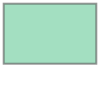

In [144]:
# Plot interactive map to select area
from ipyleaflet import basemaps, basemap_to_tiles
from odc.ui import select_on_a_map
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geom = select_on_a_map(height="600px", layers=(basemap,), center=(-26, 135), zoom=4)
geom

In [174]:
# query_params = dict(
#     region_code="x092y144",
# )

# t, l = -20.631935, 117.172988
# b, r = -20.674714, 117.204857


# t, l = -20.79532, 116.45943
# b, r = -20.81130, 116.49535


# t, l = -16.01203, 137.24871
# b, r = -16.03479, 137.27490

# t, l = -14.15179, 136.39488
# b, r = -14.17439, 136.42065

# t, l = -20.28695, 118.57847
# b, r = -20.31949, 118.65429


query_params = dict(
    # x=(l, r),
    # y=(t, b),
    geopolygon=geom,
)


load_params = dict(
    measurements=["elevation", "lot", "hot"],  #, "qa_ndwi_freq"], #, "elevation_uncertainty"],
    # dask_chunks={},
)

dss = dc.find_datasets(
    product="ga_s2ls_intertidal_cyear_3",
    **query_params,
)

ds = dc.load(
    product="ga_s2ls_intertidal_cyear_3",
    datasets=dss,
    **load_params,
    **query_params,
)

In [147]:
# elev_mins = ds.elevation.min(dim=["x", "y"])
# elev_maxs = ds.elevation.max(dim=["x", "y"])
# fill_da = xr.where(ds.qa_ndwi_freq > 50, elev_mins, elev_maxs)
# elevation = ds.elevation.fillna(fill_da)

/tmp/ipykernel_1275/2749920441.py:9: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  elevation_processed1 = elevation.groupby("time").apply(lambda x: tpi(xr.DataArray(x))).fillna(0)
/tmp/ipykernel_1275/2749920441.py:10: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  elevation_processed2 = elevation.groupby("time").apply(lambda x: tpi(xr.DataArray(x), 10)).fillna(0)


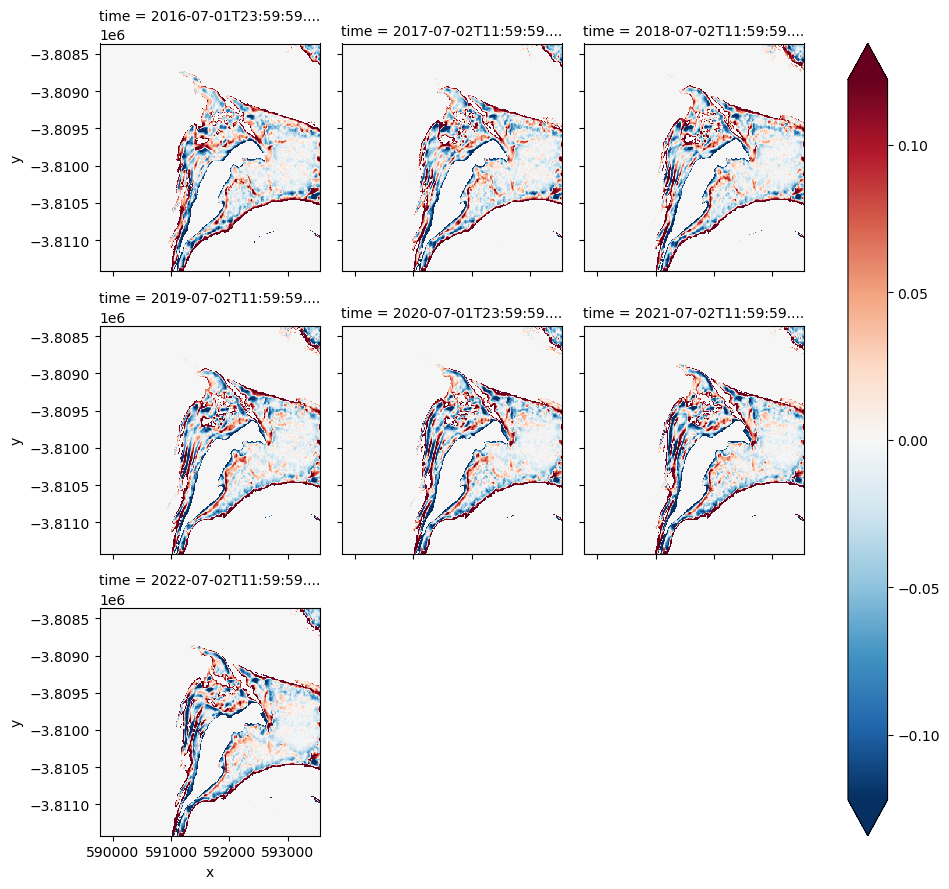

In [177]:
def tpi(da, radius=5):
    return (focal_stats(da, kernel=disk(radius), stats_funcs=["mean"]).squeeze() - da)

# elevation = ds.elevation
lot_max = ds.lot.max(dim="time")
hot_min = ds.hot.min(dim="time")
elevation = ds.elevation.where((ds.elevation > lot_max) & (ds.elevation < hot_min))

elevation_processed1 = elevation.groupby("time").apply(lambda x: tpi(xr.DataArray(x))).fillna(0)
elevation_processed2 = elevation.groupby("time").apply(lambda x: tpi(xr.DataArray(x), 10)).fillna(0)
elevation_processed = (elevation_processed1 + elevation_processed2) / 2.0
# elevation_mask = elevation.notnull().all(dim="time")
# elevation_processed = elevation_processed.where(elevation_mask, 0)
elevation_processed.plot.imshow(col="time", col_wrap=3, robust=True)

In [149]:
# elevation = ds.elevation
# elevation_mask = elevation.notnull().all(dim="time")
# elevation_processed = elevation.groupby("time").apply(feature.canny, 3).fillna(0) 
# elevation_processed.plot.imshow(col="time", col_wrap=3)

Exporting animation to /home/jovyan/Robbi/dea-intertidal/animation.gif


  0%|          | 0/7 (0.0 seconds remaining at ? frames/s)

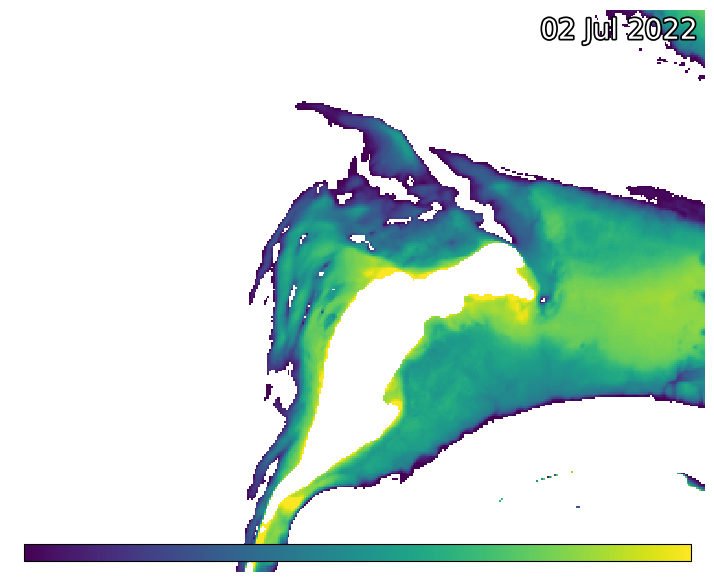

In [178]:
from dea_tools.plotting import xr_animation
xr_animation(
    elevation.to_dataset(name="elevation"),
    bands="elevation",
    output_path="/home/jovyan/Robbi/dea-intertidal/animation.gif",
    percentile_stretch=(0.01, 0.99),
    imshow_kwargs={"cmap": "viridis"},
)

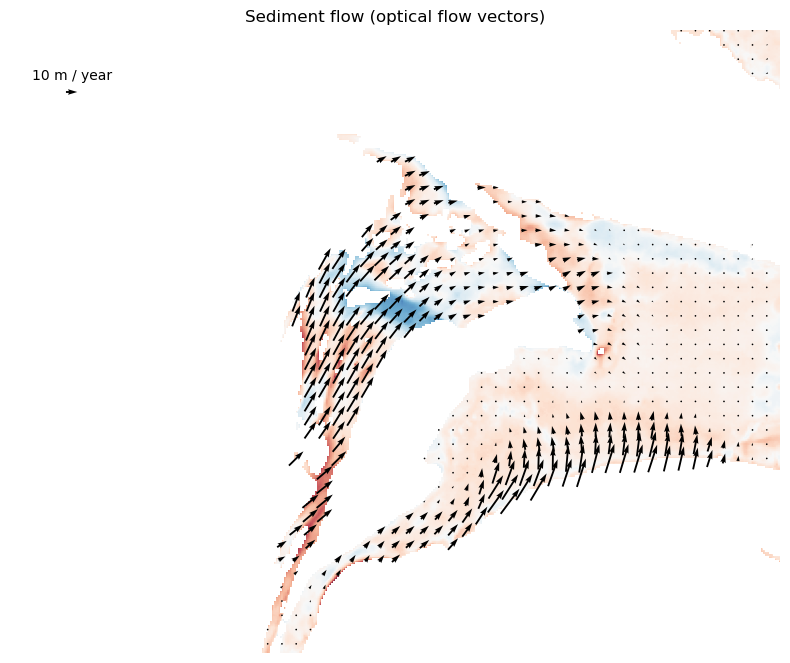

In [180]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.registration import optical_flow_tvl1, optical_flow_ilk
import math


def calculate_flow_for_dataset(da):
    vi = []
    ui = []

    # Calculate flow for each pair of consecutive timesteps
    for t in range(len(da.time) - 1):
        image0 = da.isel(time=t)
        image1 = da.isel(time=t + 1)

        v, u = optical_flow_ilk(image0, image1, radius=20)

        vi.append(v)
        ui.append(u)

    # Convert to xarray DataArrays
    v_da = xr.DataArray(
        np.stack(vi),
        dims=("time", "y", "x"),
        coords={"time": da.time[1:], "y": da.y, "x": da.x},
    )

    u_da = xr.DataArray(
        np.stack(ui),
        dims=("time", "y", "x"),
        coords={"time": da.time[1:], "y": da.y, "x": da.x},
    )

    return v_da, u_da


def transform_curved_shoreline_vectorized(x_array, y_array, theta_array):
    """
    Transform 2D raster arrays of movement vectors to shoreline-relative coordinates,
    with a different shoreline angle for each pixel, using vectorized operations.
    
    Parameters:
    x_array, y_array: 2D NumPy arrays of x and y components of the original vectors
    theta_array: 2D NumPy array of shoreline angles (in radians) for each pixel
    
    Returns:
    parallel, perpendicular: 2D arrays of transformed vector components
    """
    # Ensure all input arrays have the same shape
    assert x_array.shape == y_array.shape, "Input arrays must have the same shape"
    
    # Compute sine and cosine of theta_array
    cos_theta = np.cos(theta_array)
    sin_theta = np.sin(theta_array)
    
    # Compute parallel and perpendicular components
    parallel = x_array * cos_theta - y_array * sin_theta
    perpendicular = x_array * sin_theta + y_array * cos_theta
    
    return parallel, perpendicular


v_da, u_da = calculate_flow_for_dataset(elevation_processed)
# v = v_da.median(dim="time").where(elevation_mask)
# u = u_da.median(dim="time").where(elevation_mask)
v = v_da.mean(dim="time").where(elevation_mask)
u = u_da.mean(dim="time").where(elevation_mask)


# --- Display
fig, ax0 = plt.subplots(1, 1, figsize=(8, 8))
nvec = 50  # Number of vectors to be displayed along each image dimension
nl, nc = elevation_processed.isel(time=0).shape
step = max(nl // nvec, nc // nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u_ = u[::step, ::step]
v_ = v[::step, ::step]

# Plot difference over time (to replace with regression)
diff = elevation.isel(time=-1) - elevation.isel(time=0)
ax0.imshow(diff, cmap="RdBu", vmin=-1, vmax=1, alpha=0.8)

# Add individual arrows showing flow
Q = ax0.quiver(
    x,
    y,
    u_,
    v_,
    color="black",
    units="dots",
    angles="xy",
    scale_units="xy",
    pivot="mid",
)
qk = ax0.quiverkey(Q, 0.08, 0.9, 1, "10 m / year")
# ax0.streamplot(x,y, u_, v_, density=3, minlength=0.05, color="black")

# # Add overall change arrow
# Q = ax0.quiver(
#     200,
#     100,
#     u.median(),
#     v.median(),
#     color="red",
#     units="dots",
#     angles="xy",
#     scale_units="xy",
#     pivot="mid",
# )

ax0.set_title("Sediment flow (optical flow vectors)")
ax0.set_axis_off()
fig.tight_layout()

plt.show()

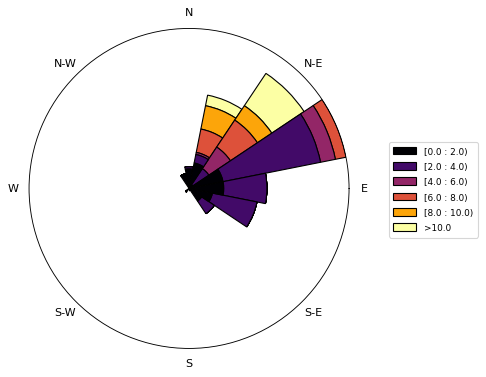

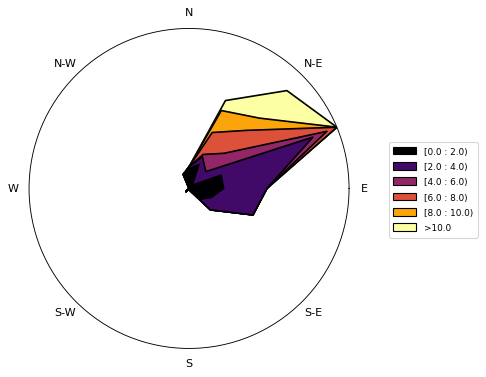

In [152]:
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Create wind speed and direction variables
cell_size = 10
df = pd.DataFrame({"u": u_.data.flatten(), "v": v_.data.flatten()})
df["magnitude"] = np.sqrt(df.u**2 + df.v**2) * cell_size
df["angle"] = (90 + np.degrees(np.arctan2(df.v, df.u))) % 360
df = df.dropna()
df = df.query("magnitude > 1")

ax = WindroseAxes.from_ax(figsize=(5, 5))
ax.bar(
    df["angle"],
    df["magnitude"],
    nsector=16,
    normed=True,
    opening=1,
    edgecolor="black",
    bins=[0, 2, 4, 6, 8, 10],
    cmap=cm.inferno,
)
ax.set_yticklabels([])
ax.grid(linestyle="--", alpha=0.0)
ax.set_axisbelow(True)
ax.set_legend(loc="lower right", bbox_to_anchor=(1.4, 0.35))


ax = WindroseAxes.from_ax(figsize=(5, 5))
ax.contourf(df["angle"], df["magnitude"], nsector=16, bins=[0, 2, 4, 6, 8, 10], cmap=cm.inferno)
ax.contour(df["angle"], df["magnitude"], nsector=16, bins=[0, 2, 4, 6, 8, 10], colors='black')
ax.set_yticklabels([])
ax.grid(linestyle="--", alpha=0.0)
ax.set_axisbelow(True)
ax.set_legend(loc="lower right", bbox_to_anchor=(1.4, 0.35))

In [ ]:
df = px.data.wind()
df

# df = xr.Dataset({"u": u, "v": -v, "speed": speed_magnitude}).isel(x=slice(None, None, 10), y=slice(None, None, 10)).to_dataframe()
# df


# fig = px.bar_polar(df, r="frequency", theta="direction",
#                    color="strength", template="plotly_dark",
#                    color_discrete_sequence= px.colors.sequential.Plasma_r)
# # fig.show()

In [ ]:
# xr.Dataset({"u": u, "v": v}).coarsen(x=10, y=10, boundary="trim").mean().plot.quiver(x="x", y="y", u="u", v="v")
# xr.Dataset({"u": u, "v": v}).coarsen(x=10, y=10, boundary="trim").mean().plot.quiver(x="x", y="y", u="u", v="v", scale=10)

# Convert flow to meters per second
v_speed = (v * 10)
u_speed = (u * 10)
speed_magnitude = np.sqrt(v_speed**2 + u_speed**2)
speed_magnitude = 10


plot_ds = xr.Dataset({"u": u, "v": -v, "speed": speed_magnitude}).isel(x=slice(None, None, 10), y=slice(None, None, 10))

# plot_ds.plot.quiver(x="x", y="y", u="u", v="v", add_guide=True,  hue="speed", hue_style="continuous")



In [ ]:
# plot_ds.speed.plot()

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
lim = 1
u.plot.imshow(ax=axes[0], cmap="RdBu", vmin=-lim, vmax=lim)
v.plot.imshow(ax=axes[1], cmap="RdBu", vmin=-lim, vmax=lim)
parallel, perpendicular = transform_curved_shoreline_vectorized(u, v, math.radians(-45))
# parallel, perpendicular = transform_curved_shoreline_vectorized(u, v, theta_da.angles)
parallel.plot.imshow(ax=axes[2], cmap="RdBu", vmin=-lim, vmax=lim)
perpendicular.plot.imshow(ax=axes[3], cmap="RdBu", vmin=-lim, vmax=lim)
# coastline_gdf.plot(ax=axes[2], color="black")
# coastline_gdf.plot(ax=axes[3], color="black")
axes[0].set_title("Horizontal (x)")
axes[1].set_title("Vertical (y)")
axes[2].set_title("Along-shore (parallel)")
axes[3].set_title("Cross-shore (perpendicular)");

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def plot_windrose(u, v, cell_size=10, num_bins=32, vmin=0, vmax=None):

    # Calculate magnitude and angle
    magnitude = np.sqrt(u**2 + v**2) * cell_size
    
    # Angle calculation to point in the direction of movement
    angle = np.degrees(np.arctan2(v, u)) % 360

    # Print some debug information
    print(f"Number of vectors: {len(u)}")
    print(f"Magnitude range: {np.min(magnitude)} to {np.max(magnitude)}")
    print(f"Angle range: {np.min(angle)} to {np.max(angle)}")

    # Check if we have any non-zero vectors
    if np.all(magnitude == 0):
        print("All vectors have zero magnitude. Cannot create windrose plot.")
        return

    # Create bins for angles
    angle_bins = np.linspace(0, 360, num_bins + 1)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection="polar"))

    # Plot histogram and calculate mean magnitudes
    hist, _ = np.histogram(angle, bins=angle_bins)
    width = (2 * np.pi) / num_bins
    mean_magnitudes = np.array(
        [
            np.mean(magnitude[(angle >= angle_bins[i]) & (angle < angle_bins[i + 1])])
            for i in range(len(angle_bins) - 1)
        ]
    )

    # Set color scale
    if vmin is None:
        vmin = np.nanmin(mean_magnitudes)
    if vmax is None:
        vmax = np.nanmax(mean_magnitudes)

    # Create color map
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    
    
    from matplotlib.ticker import PercentFormatter

    # Plot bars with colors
    bars = ax.bar(
        np.deg2rad(angle_bins[:-1]),
        hist,
        width=width,
        bottom=0.0,
        color=cmap(norm(mean_magnitudes)),
        edgecolor='black',
        linewidth=0.5,
    )

    # Set up the axes
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(-1)
    ax.set_thetagrids(
        np.arange(0, 360, 45), ["E", "NE", "N", "NW", "W", "SW", "S", "SE"]
    )

    # Hide the radial tick labels
    ax.set_yticklabels([])
    ax.set_axisbelow(True)
    ax.grid(linestyle='--', alpha=0.5) 

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", pad=0.08, aspect=25, shrink=0.5)
    cbar.set_label("Mean movement rate (m / year)")

    ax.set_title("Sediment flow direction")
    plt.tight_layout()
    plt.show()


# Assuming u and v are your vector components
# Flatten the arrays if they're 2D
u_flat = u_.data.flatten()
v_flat = v_.data.flatten()

# Remove any NaN values
mask = ~(np.isnan(u_flat) | np.isnan(v_flat))
u_flat = u_flat[mask]
v_flat = v_flat[mask]

plot_windrose(u_flat, v_flat)

In [ ]:
cell_size = 10
num_angle_bins = 32

u_flat = u_.data.flatten()
v_flat = v_.data.flatten()

# magnitude = np.sqrt(u_flat**2 + v_flat**2) * cell_size
# angle = np.degrees(np.arctan2(v, u)) % 360

In [ ]:

def vector_to_angle(x, y):
    angle_rad = np.arctan2(x, y)
    angle_deg = np.degrees(angle_rad)
    adjusted_angle = (90 - angle_deg) % 360
    return adjusted_angle


df = pd.DataFrame({"u": u_.data.flatten(), "v": v_.data.flatten()})
df["magnitude"] = np.sqrt(df.u**2 + df.v**2) * cell_size
df["angle"] = vector_to_angle(df.u, df.v)  #np.degrees(np.arctan2(df.v, df.u)) % 360
df = df.dropna()

# Magnitude bins
x_bins = pd.cut(df['magnitude'], bins=10, labels=False)

# Angle bins
bins = np.linspace(0, 360, 17)+11.25
bins = np.insert(bins, 0, 0)
names = ['N','NNE','NE','ENE','E','ESE','SE','SSE','S','SSW','SW','WSW','W','WNW','NW','NNW', 'N2']
y_bins = pd.cut(df['angle'], bins, labels=names).replace('N2', 'N')


# Create the 2D histogram
df_hist = df.groupby([x_bins, y_bins]).size().reset_index(name="count")


import plotly.express as px
fig = px.bar_polar(df_hist, r="count", theta="angle",
                   color="magnitude", #template="plotly_dark",
                   # color_discrete_sequence= px.colors.sequential.Plasma_r,
                  )
fig.show()

In [ ]:
def deg_to_text(deg):
    return ["N","NNE","NE","ENE","E","ESE", "SE", "SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"][round(deg/22.5)%16]

In [ ]:
deg_to_text(df["angle"].values)

In [ ]:
df["angle_bins"] = y_bins

In [ ]:
df.groupby("angle_bins").angle.mean()

In [ ]:
df.groupby("angle_bins").angle.count()

In [ ]:
df["angle"].plot.hist()

In [ ]:
df

In [ ]:
# import plotly.express as px
df = px.data.wind()
df
# fig = px.bar_polar(df, r="frequency", theta="direction",
#                    color="strength", template="plotly_dark",
#                    color_discrete_sequence= px.colors.sequential.Plasma_r)
# fig.show()

In [ ]:
hist_2d

In [ ]:
hist_2d

In [ ]:
# Create bins for angles and magnitudes
angle_bins = np.linspace(0, 360, num_angle_bins + 1)
# magnitude_bins = np.linspace(np.min(magnitude), np.max(magnitude), num_magnitude_bins + 1)
magnitude_bins = [0, 2, 4, 6, 8, 10, 100]

# Set up the plot
# fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection="polar"))

# Calculate histogram
hist, _, _ = np.histogram2d(df.angle, df.magnitude, bins=[angle_bins, magnitude_bins])

In [ ]:
hist

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

def plot_windrose(u, v, cell_size=10, num_angle_bins=32, num_magnitude_bins=5, vmin=0, vmax=None):
    # Calculate magnitude and angle
    magnitude = np.sqrt(u**2 + v**2) * cell_size
    angle = np.degrees(np.arctan2(v, u)) % 360

    # Print debug information
    print(f"Number of vectors: {len(u)}")
    print(f"Magnitude range: {np.min(magnitude)} to {np.max(magnitude)}")
    print(f"Angle range: {np.min(angle)} to {np.max(angle)}")

    # Check if we have any non-zero vectors
    if np.all(magnitude == 0):
        print("All vectors have zero magnitude. Cannot create windrose plot.")
        return

    # Create bins for angles and magnitudes
    angle_bins = np.linspace(0, 360, num_angle_bins + 1)
    # magnitude_bins = np.linspace(np.min(magnitude), np.max(magnitude), num_magnitude_bins + 1)
    magnitude_bins = [0, 2, 4, 6, 8, 10, 100]

    # Set up the plot
    fig, ax = plt.subplots(figsize=(5, 5), subplot_kw=dict(projection="polar"))

    # Calculate histogram
    hist, _, _ = np.histogram2d(angle, magnitude, bins=[angle_bins, magnitude_bins])

    # Set color scale
    if vmin is None:
        vmin = np.min(magnitude_bins[:-1])
    if vmax is None:
        vmax = np.max(magnitude_bins[:-1])

    # Create color map
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    # Plot stacked bars
    width = (2 * np.pi) / num_angle_bins
    bottom = np.zeros(num_angle_bins)

    for i in range(num_magnitude_bins):
        values = hist[:, i]
        ax.bar(
            np.deg2rad(angle_bins[:-1]),
            values,
            width=width,
            bottom=bottom,
            color=cmap(norm(magnitude_bins[i])),
            edgecolor='black',
            linewidth=0.5,
        )
        bottom += values

    # Set up the axes
    ax.set_theta_zero_location("E")
    ax.set_theta_direction(-1)
    ax.set_thetagrids(
        np.arange(0, 360, 45), ["E", "NE", "N", "NW", "W", "SW", "S", "SE"]
    )

    # Set radial ticks
    ax.set_rticks(np.arange(0, ax.get_rmax(), ax.get_rmax()/5))  # 5 ticks
    ax.set_yticklabels([f'{int(x)}' for x in ax.get_yticks()])

    ax.set_axisbelow(True)
    ax.grid(linestyle='--', alpha=0.5)

    # # Add colorbar
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # sm.set_array([])
    # cbar = fig.colorbar(sm, ax=ax, orientation="horizontal", pad=0.08, aspect=25, shrink=0.6)
    # cbar.set_label("Movement rate (m / year)")

    # Add legend for magnitude bins
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=cmap(norm(m)), edgecolor='black', linewidth=0.5)
                       for m in magnitude_bins[:-1]]
    legend_labels = [f'{magnitude_bins[i]:.1f} - {magnitude_bins[i+1]:.1f}' for i in range(len(magnitude_bins)-1)]
    ax.legend(legend_elements, legend_labels, title="Sediment movement (m/year)", 
              loc='center left', bbox_to_anchor=(1.1, 0.5))

    ax.set_title("Sediment flow direction and magnitude")
    plt.tight_layout()
    plt.show()

# Assuming u and v are your vector components
# Flatten the arrays if they're 2D
u_flat = u_.data.flatten()
v_flat = v_.data.flatten()

# Remove any NaN values
mask = ~(np.isnan(u_flat) | np.isnan(v_flat))
u_flat = u_flat[mask]
v_flat = v_flat[mask]

plot_windrose(u_flat, v_flat)

### Shoreline angle

In [ ]:
import geopandas as gpd

coastline_gdf = gpd.read_file(
    "https://data.dea.ga.gov.au/derivative/dea_coastlines/supplementary/Smartline.gpkg",
    # "/gdata1/data/beach_slopes/Australia_slopes_by_beach.geojson",
    # "/gdata1/data/boundaries/GEODATA_COAST_100K/australia/cstauscd_l.shp",
    bbox=ds.odc.geobox.boundingbox.to_crs("EPSG:4326"),
).to_crs(ds.odc.geobox.crs)
coastline_gdf["geometry"] = coastline_gdf.geometry.simplify(100)

In [ ]:
coastline_gdf = gpd.read_file(
    "/gdata1/data/boundaries/GEODATA_COAST_100K/australia/cstauscd_r.shp",
    bbox=ds.odc.geobox.boundingbox.to_crs("EPSG:4326"),
).to_crs(ds.odc.geobox.crs).query("FEAT_CODE == 'mainland'")
# coastline_gdf["geometry"] = coastline_gdf.geometry.simplify(100)

In [ ]:
coastline_gdf["geometry"] = coastline_gdf.geometry.exterior

In [ ]:
import geopandas as gpd
import numpy as np
from shapely.geometry import Point


def split_lines_to_segments(gdf):

    # Func to loop through coordinates and convert to LineString segments
    def _create_segments(row):
        coords = list(row.geometry.coords)
        segments = [LineString(coords[i : i + 2]) for i in range(len(coords) - 1)]
        return gpd.GeoDataFrame([row] * len(segments), geometry=segments, crs=gdf.crs)
    
    # Convert any multilines to lines first for consistent handling
    gdf = gdf.explode(ignore_index=True)

    # Loop through each row in GeoDataFrame, then return and combine segments
    return gpd.GeoDataFrame(
        pd.concat(
            [_create_segments(row) for _, row in gdf.iterrows()], ignore_index=True
        )
    )


def calculate_angles_line(gdf, degrees=False):
    # Ensure the GeoDataFrame is using a projected CRS
    if not gdf.crs or gdf.crs.is_geographic:
        raise ValueError("Please use a projected coordinate system")

    def segment_angle(p1, p2):
        return np.arctan2(p2.y - p1.y, p2.x - p1.x)

    angles = []
    for line in gdf.geometry:
        coords = list(line.coords)
        if len(coords) != 2:
            raise ValueError("Each line must have exactly two coordinates (start and end)")
        
        start, end = coords
        angle = segment_angle(Point(start), Point(end))
        
        if degrees:
            angles.append(math.degrees(angle))
        else:
            angles.append(angle)

    return angles




In [ ]:
segments_gdf = split_lines_to_segments(coastline_gdf)
segments_gdf["angles"] = calculate_angles_line(segments_gdf, degrees=False)
segments_gdf['geometry'] = segments_gdf.geometry.centroid

In [ ]:
from dea_tools.spatial import xr_interpolate

In [ ]:
fig, ax = plt.subplots(1, 1)
theta_da = xr_interpolate(ds, segments_gdf, columns=["angles"], method="nearest")
theta_da.angles.plot.imshow(ax=ax, cmap="hsv")
segments_gdf.plot(ax=ax, column="angles", cmap="hsv", edgecolor="black")
coastline_gdf.plot(ax=ax, color="black")

In [ ]:
ax.set_

In [ ]:
from matplotlib import animation
from IPython.display import HTML


import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation





# --- Display
fig, ax0 = plt.subplots(1, 1, figsize=(8, 8))
nvec = 50  # Number of vectors to be displayed along each image dimension
nl, nc = elevation_processed.isel(time=0).shape
step = max(nl // nvec, nc // nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u_ = u[::step, ::step]
v_ = v[::step, ::step]

# Plot difference over time (to replace with regression)
diff = elevation.isel(time=-1) - elevation.isel(time=0)
ax0.imshow(diff, cmap="RdBu", vmin=-1, vmax=1, alpha=0.8)


# Add individual arrows showing flow
Q = ax0.quiver(
    x,
    y,
    u_,
    v_,
    color="black",
    units="dots",
    angles="xy",
    scale_units="xy",
    pivot="mid",
)
# qk = ax0.quiverkey(Q, 0.08, 0.9, 1, "10 m / year")



# X, Y = np.mgrid[:2*np.pi:10j,:2*np.pi:5j]
# U = np.cos(X)
# V = np.sin(Y)

# fig, ax = plt.subplots(1,1)
# Q = ax.quiver(X, Y, U, V, pivot='mid', color='r', units='inches')

# ax.set_xlim(-1, 7)
# ax.set_ylim(-1, 7)



def update_quiver(num, Q, u, v):
    """updates the horizontal and vertical vector components by a
    fixed increment on each frame
    """

    U = 0 + (u * (num * 0.1))
    V = 0 + (v * (num * 0.1))
    Q.set_UVC(U,V)

    return Q,

# you need to set blit=False, or the first set of arrows never gets
# cleared on subsequent frames
anim = animation.FuncAnimation(fig, update_quiver, fargs=(Q, u_, v_),
                               interval=50, blit=False, save_count=10)
HTML(anim.to_html5_video())

In [ ]:
0 + (u_ * (1 * 0.1))

In [ ]:
u_

In [ ]:
x.shape

In [ ]:
ax0.quiverkey(Q, 0.9, 0.9, 2, "Test", labelpos='E', coordinates='figure')

In [ ]:
# Convert flow to meters per second
v_speed = (v * 10)
u_speed = (u * 10)

# Calculate magnitude of speed (combines both components)
speed_magnitude = np.sqrt(v_speed**2 + u_speed**2)
speed_magnitude.plot.hist(bins=20)

In [ ]:
plt.imshow(speed_magnitude > 10)

In [ ]:
edges

In [ ]:
elevation.to_dataset()

In [ ]:
import xarray as xr
import numpy as np
from skimage import registration
from skimage.util import img_as_float

def calculate_optical_flow(prev, next):
    # Convert to float
    prev = img_as_float(prev)
    next = img_as_float(next)
    
    # Calculate optical flow
    flow = registration.optical_flow_tvl1(prev, next)

    return flow

def flow_to_polar(flow):
    # Convert cartesian flow to polar coordinates
    magnitude = np.sqrt(flow[0, ...]**2 + flow[1, ...]**2)
    angle = np.arctan2(flow[1, ...], flow[0, ...])
    return magnitude, angle

# Assuming your data is in a DataArray named 'elevation'
# elevation = xr.open_dataarray('elevation_data.nc')

def calculate_flow_for_dataset(da):
    flow_directions = []
    flow_speeds = []

    # Calculate flow for each pair of consecutive timesteps
    for t in range(len(da.time) - 1):
        elevation1 = da.isel(time=t).values
        elevation2 = da.isel(time=t+1).values
        
        flow = calculate_optical_flow(elevation1, elevation2)
        magnitude, angle = flow_to_polar(flow)
        
        flow_speeds.append(magnitude)
        flow_directions.append(angle)


    # Convert to xarray DataArrays
    # Note: We adjust the coordinates to match the flow dimensions
    flow_speed = xr.DataArray(np.stack(flow_speeds), 
                              dims=('time', 'y', 'x'),
                              coords={'time': da.time[:-1], 
                                      'y': da.y, 
                                      'x': da.x})

    flow_direction = xr.DataArray(np.stack(flow_directions), 
                                  dims=('time', 'y', 'x'),
                                  coords={'time': da.time[:-1], 
                                          'y': da.y, 
                                          'x': da.x})

    return flow_speed, flow_direction

# Calculate flow
flow_speed, flow_direction = calculate_flow_for_dataset(elevation)

# Create a dataset with the results
ds = xr.Dataset({
    'flow_speed': flow_speed,
    'flow_direction': flow_direction
})

# Save the result
# ds.to_netcdf('coastal_flow_continuous.nc')

# Visualize the results for the first time step
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(121)
speed_plot = plt.imshow(flow_speed.isel(time=0), cmap='viridis')
plt.colorbar(speed_plot, label='Flow Speed')
plt.title('Flow Speed (First Time Step)')

plt.subplot(122)
y, x = np.mgrid[0:flow_speed.shape[1]:20, 0:flow_speed.shape[2]:20]
u = np.cos(flow_direction.isel(time=0))[::20, ::20]
v = np.sin(flow_direction.isel(time=0))[::20, ::20]
plt.quiver(x, y, u, v, scale=20, color='red')
plt.imshow(flow_direction.isel(time=0), cmap='hsv', alpha=0.3)
plt.colorbar(label='Flow Direction (radians)')
plt.title('Flow Direction (First Time Step)')

plt.tight_layout()
# plt.savefig('flow_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
elevation = ds.elevation
edges = elevation.groupby("time").apply(feature.canny)
time_1 = edges.isel(time=0)
time_2 = edges.isel(time=3)
# mask = elevation.isel(time=0).notnull() & elevation.isel(time=3).notnull()

elevation_tpi = elevation.groupby("time").apply(lambda x: tpi(xr.DataArray(x))).fillna(0)
mask = elevation.notnull().all(dim="time")
elevation_tpi_masked = elevation_tpi.where(mask, 0)
elevation_tpi_masked.plot(col="time", col_wrap=3)
time_1 = elevation_tpi_masked.isel(time=0)
time_2 = elevation_tpi_masked.isel(time=3)



flow = calculate_optical_flow(time_1,  time_2)
# magnitude, angle = flow_to_polar(flow)

# flow[0, ~mask.values] = np.nan
# flow[1, ~mask.values] = np.nan
# magnitude[~mask.values] = np.nan
# angle[~mask.values] = np.nan

In [ ]:
u_da.plot.imshow(col="time", col_wrap=3, robust=True)

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.color import rgb2gray
from skimage.data import stereo_motorcycle, vortex
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1, optical_flow_ilk



# elevation = ds.elevation
# edges = elevation.groupby("time").apply(feature.canny)
# image0 = edges.isel(time=5)
# image1 = edges.isel(time=6)
# mask = elevation.isel(time=0).notnull() & elevation.isel(time=3).notnull()

elevation_tpi = elevation.groupby("time").apply(lambda x: tpi(xr.DataArray(x))).fillna(0)
mask = elevation.notnull().all(dim="time")
elevation_tpi_masked = elevation_tpi.where(mask, 0)
# elevation_tpi_masked.plot(col="time", col_wrap=3)
image0 = elevation_tpi_masked.isel(time=1)
image1 = elevation_tpi_masked.isel(time=2)

# --- Compute the optical flow
v, u = optical_flow_ilk(image0, image1, radius=30)

# --- Compute flow magnitude
norm = np.sqrt(u**2 + v**2)

# --- Display
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 4))

# --- Sequence image sample

ax0.imshow(image0, cmap='gray')
ax0.set_title("Sequence image sample")
ax0.set_axis_off()

# --- Quiver plot arguments

nvec = 20  # Number of vectors to be displayed along each image dimension
nl, nc = image0.shape
step = max(nl // nvec, nc // nvec)

y, x = np.mgrid[:nl:step, :nc:step]
u_ = u[::step, ::step]
v_ = v[::step, ::step]

# ax1.imshow(norm)
# ax1.imshow(image1, cmap='gray')
ax1.imshow(image1 - image0, cmap="RdBu", vmin=-0.3, vmax=0.3)
ax1.quiver(x, y, u_, v_, color='r', units='dots', angles='xy', scale_units='xy')
ax1.set_title("Optical flow magnitude and vector field")
ax1.set_axis_off()
fig.tight_layout()

plt.show()

In [ ]:
plt.imshow(image0)

In [ ]:
plt.imshow(image1 - image0, cmap="RdBu")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming flow has shape (2, 100, 359)

# Define a step size for downsampling
step = 10  # Adjust this value to change the density of arrows

# Create a grid of points
h, w = flow.shape[1:]
y, x = np.mgrid[0:h:step, 0:w:step]

# Extract the u (x) and v (y) components of the flow
u = flow[0, ::step, ::step]
v = flow[1, ::step, ::step]

# Create the quiver plot
plt.figure(figsize=(15, 6))
plt.quiver(x, y, u, v, scale=5, scale_units='inches', color='r')
plt.xlim(0, w)
plt.ylim(h, 0)  # Invert y-axis to match image coordinates
plt.title('Optical Flow (Downsampled)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
(elevation.isel(time=0) - elevation.isel(time=3)).plot(cmap="RdBu", vmin=-0.3, vmax=0.3)

In [ ]:
magnitude[~mask.values] = np.nan
angle[~mask.values] = np.nan

In [ ]:

fig, ax = plt.subplots(figsize=(4,4))
im = plt.imshow(angle, cmap="hsv", label="test")
ax.set_xlabel("x label")

fig.colorbar(im, orientation="horizontal", pad=0.2)
plt.show()


In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12,8))


# plt.subplot(121)
speed_plot = axes[0].imshow(magnitude, cmap='viridis')
plt.colorbar(speed_plot, label='Flow Speed')
plt.title('Flow Speed (First Time Step)')

# plt.subplot(122)
y, x = np.mgrid[0:magnitude.shape[0]:20, 0:magnitude.shape[1]:20]
u = np.cos(angle[::20, ::20])
v = np.sin(angle[::20, ::20])
axes[1].quiver(x, y, u, v, scale=20, color='red')
axes[1].imshow(angle, cmap='hsv', alpha=0.3)
# plt.colorbar(label='Flow Direction (radians)')
# plt.title('Flow Direction (First Time Step)')

In [ ]:
magnitude.shape[1]

In [ ]:
0:magnitude.shape[1]:20

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Assuming flow_speed and flow_direction are your xarray DataArrays

# Calculate average speed across all time steps
avg_speed = flow_speed.mean(dim='time')

# Calculate average direction
sin_sum = np.sin(flow_direction).mean(dim='time')
cos_sum = np.cos(flow_direction).mean(dim='time')
avg_direction = np.arctan2(sin_sum, cos_sum)

# Calculate standard deviation of speed changes
speed_std = flow_speed.std(dim='time')

# Create a significance mask (e.g., changes greater than 2 standard deviations)
significance_mask = (avg_speed > (1.5 * speed_std)).values & ~elevation.isnull().all(dim="time").values

# Create a quiver plot
plt.figure(figsize=(12, 10))

# Plot average speed as a color map
speed_plot = plt.imshow(avg_speed, cmap='viridis')
speed_plot = plt.imshow(elevation.isel(time=0), cmap='viridis')
# plt.colorbar(speed_plot, label='Average Speed')

# Create a grid for quiver plot
ny, nx = avg_speed.shape
x, y = np.meshgrid(np.arange(nx), np.arange(ny))

# Subsample the grid to avoid overcrowding arrows
step = 5  # Adjust this value to change arrow density

# Apply the mask to the coordinates and directions
mask = significance_mask[::step, ::step]
x_masked = x[::step, ::step][mask]
y_masked = y[::step, ::step][mask]
u_masked = np.cos(avg_direction.values)[::step, ::step][mask]
v_masked = np.sin(avg_direction.values)[::step, ::step][mask]

# Plot average direction as arrows, only for significant changes
quiv = plt.quiver(x_masked, y_masked, u_masked, v_masked, 
                  scale=25, color='white')

plt.title('Average Coastal Change: Speed and Direction')
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')

# Add a key for arrow scale
plt.quiverkey(quiv, 0.9, 0.9, 1, 'Unit Vector', labelpos='E', coordinates='figure')

# plt.savefig('average_coastal_change_quiver.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
flow_speed.mean(dim="time")

In [ ]:
ds

In [ ]:
import xarray as xr
import numpy as np
from skimage import registration
from skimage.util import img_as_float

def calculate_optical_flow(prev, next):
    # Convert to float
    prev = img_as_float(prev)
    next = img_as_float(next)
    
    # Calculate optical flow
    flow = registration.optical_flow_tvl1(prev, next)
    
    return flow

def flow_to_polar(flow):
    # Convert cartesian flow to polar coordinates
    magnitude = np.sqrt(flow[0, ...]**2 + flow[1, ...]**2)
    angle = np.arctan2(flow[1, ...], flow[0, ...])
    return magnitude, angle


In [ ]:
# .plot.imshow()

In [ ]:
prev = ds.elevation.isel(time=0).fillna(0)
next = ds.elevation.isel(time=5).fillna(0)

flow = calculate_optical_flow(prev, next)
magnitude, angle = flow_to_polar(flow)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(angle)

In [ ]:
# Plot average speed as a color map
speed_plot = plt.imshow(magnitude, cmap='viridis')
plt.colorbar(speed_plot, label='Average Speed')

# Plot dominant direction as arrows
y, x = np.mgrid[0:magnitude.shape[0]:20, 0:magnitude.shape[1]:20]
u = np.cos(angle[::20, ::20])
v = np.sin(angle[::20, ::20])
plt.quiver(x, y, u, v, scale=None, color='white')

In [ ]:
regression_ds = xr_regression(x=ds.time.dt.year, y=ds.elevation.isel(time=slice(2, 10)))

In [ ]:
len(ds.elevation.isel(time=slice(2, 10))["time"])

In [ ]:
regression_ds.pvalue.plot.imshow(vmin=0, vmax=1, cmap="viridis_r", size=20)

In [ ]:
(dim in y.dims) & (dim in y.rename(time="boo").dims)

In [ ]:
regression_ds.pvalue.plot.imshow(vmin=0, vmax=1, cmap="viridis_r", size=20)

In [ ]:
regression_ds.n.plot.imshow(vmin=0, vmax=7, cmap="viridis_r", size=20)

In [ ]:
regression_ds.n.plot.imshow(vmin=0, vmax=7, cmap="viridis_r", size=20)

In [ ]:
x, y = xr_regression(y=ds.elevation, x=ds.time.dt.year, lag_y=0, lag_x=3)

In [ ]:
regression_ds.n.plot.imshow(vmin=0, vmax=7, cmap="RdBu", size=15)

In [ ]:
regression_ds.n.plot.imshow(vmin=0, vmax=7, cmap="RdBu", size=15)

In [ ]:
y.plot.imshow(col="time")

In [ ]:
ds.elevation.shift(time= -1)   #.dropna(dim="time")

In [ ]:
y

In [ ]:
lag_x = 2
lag_y = 0
dim="time"

y=ds.elevation
x=ds.time.dt.year

# Shift x and y data if lags are specified
if lag_x != 0:
    # If x lags y by 1, x must be shifted 1 step backwards. But as
    # the 'zero-th' value is nonexistant, xarray assigns it as
    # invalid (nan). Hence it needs to be dropped
    x = x.shift(**{dim: -lag_x}).dropna(dim=dim)

    # # Next re-align the two datasets so that y adjusts to the
    # # changed coordinates of x
    # x, y = xr.align(x, y)

if lag_y != 0:
    y = y.shift(**{dim: -lag_y}).dropna(dim=dim)

# Ensure that the data are properly aligned to each other.
# x, y = xr.align(x, y)

In [ ]:
x

In [ ]:
xr.align(x, y)[1]

In [ ]:
x

In [ ]:
y

In [ ]:
regression_ds.slope.plot.imshow(vmin=-0.1, vmax=0.1, cmap="RdBu", size=20)

## Generate regression outputs

In [ ]:
grid_gdf = gpd.read_file("/home/jovyan/Robbi/dea-intertidal/data/raw/ga_summary_grid_c3_32km_coastal.geojson").set_index("region_code")
region_list = grid_gdf.index

In [ ]:
outputs = []

for region_code in tqdm.tqdm(region_list):
    
    # if not os.path.exists(f"{region_code}.nc"):

        query_params = dict(
            region_code=region_code,
        )

        load_params = dict(
            measurements=["elevation", "elevation_uncertainty"],
            dask_chunks={},
        )

        dss = dc.find_datasets(
            product="ga_s2ls_intertidal_cyear_3",
            **query_params,
        )

        if len(dss) > 0:

            ds = dc.load(
                product="ga_s2ls_intertidal_cyear_3",
                datasets=dss,
                **load_params,
            )

            # Mask by certainty
            ds = ds.where(ds.elevation_uncertainty < 0.3)
            ds.load()

            # Calculate regression between elevation values (3D) and time (1D)
            regression_ds = xr_regression(y=ds.elevation, x=ds.time.dt.year)
            
            # Add mean elevation to data
            regression_ds["elevation_mean"] = ds.elevation.mean(dim="time")

            # Export
            regression_ds.to_netcdf(f"{region_code}.nc")
            # for var in regression_ds.data_vars:
            #     regression_ds[var].odc.write_cog(f"{region_code}_{var}.tif", overwrite=True)

In [ ]:
regression_outliers_ds = xr_regression(y=ds.elevation, x=ds.time.dt.year, outliers_y=4.0)

In [ ]:
(regression_ds.pvalue - regression_outliers_ds.pvalue).plot.imshow(size=15)

In [ ]:
regression_ds.slope.odc.write_cog("slope_nooutliers.tif")

In [ ]:
x_in, y_in = xr_regression(y=ds.elevation, x=ds.time.dt.year)

In [ ]:
median = y.median(dim="time")

In [ ]:
import numpy as np
diff = ((y - median) ** 2).sum()

In [ ]:
diff

In [ ]:
points= np.expand_dims(y_in.isel(y=1588, x=1547).values, axis=1)

# MAD
median = np.median(points, axis=0)
diff = np.sum((points - median) ** 2, axis=-1)
diff = np.sqrt(diff)
# med_abs_deviation = np.median(diff)
# modified_z_score = 0.6745 * diff / med_abs_deviation

diff

In [ ]:
abs_deviation.isel(y=[1588], x=[1547])

In [ ]:
def mad_outliers(data, dim="time", threshold=3.5):
    """
    Identify outliers along an xarray dimension using Median Absolute
    Deviation (MAD).

    Parameters
    ----------
    data : xarray.DataArray)
        The input data array with dimensions time, x, y.
    threshold : float)
        The number of MADs away from the median to consider a point an 
        outlier.

    Returns
    -------
    xarray.DataArray: 
        A boolean array with the same dimensions as input data, where 
        True indicates an outlier.
    """
    # Calculate the median along the time dimension
    median = data.median(dim=dim)

    # Calculate the absolute deviations from the median
    abs_deviation = np.abs(data - median)

    # Calculate the MAD (median of the absolute deviations)
    mad = abs_deviation.median(dim=dim)

    # Deviations greater than (threshold * MAD) are considered outliers
    outliers = abs_deviation > (threshold * mad)

    return outliers

In [ ]:
y_in.sel(x=401313.475,y=-3724823.939, method="nearest").plot()

In [ ]:
outliers = mad_outliers(y_in, threshold=4)

In [ ]:
outliers.sel(x=401313.475,y=-3724823.939, method="nearest")

In [ ]:
x_coord, y_coord = 394944.107,-3738964.292

y_in.where(outliers).sel(x=x_coord,y=y_coord, method="nearest").plot.scatter()
y_in.where(~outliers).sel(x=x_coord,y=y_coord, method="nearest").plot.scatter()

In [ ]:
item = 3.6



In [ ]:
y_in.where(~outliers).plot.hist()

In [ ]:
# Calculate the median along the time dimension
median = y.median(dim='time')

# Calculate the absolute deviations from the median
abs_deviation = np.abs(y - median)

# Calculate the MAD (median of the absolute deviations)
mad = abs_deviation.median(dim='time')

mad  #.isel(y=[1588], x=[1547])

# Identify outliers: deviations greater than (threshold * MAD) are considered outliers
# outliers = abs_deviation > (threshold * mad)


In [ ]:
y = y_in  #.isel(y=[1588], x=[1547])

median = y.median(dim="time")
diff = ((y - median) ** 2)
# diff = np.sqrt(diff)
# med_abs_deviation = diff.median(dim="time")
# modified_z_score = 0.6745 * diff / med_abs_deviation

diff.isel(y=[1588], x=[1547])

In [ ]:
((y - median) ** 2).sum(time=

In [ ]:
modified_z_score

In [ ]:
points - median

In [ ]:
for region_code in tqdm.tqdm(region_list):
    
    if os.path.exists(f"{region_code}.nc"):

        query_params = dict(
            region_code=region_code,
        )

        load_params = dict(
            measurements=["elevation", "elevation_uncertainty"],
            dask_chunks={},
        )

        dss = dc.find_datasets(
            product="ga_s2ls_intertidal_cyear_3",
            **query_params,
        )

        if len(dss) > 0:

            ds = dc.load(
                product="ga_s2ls_intertidal_cyear_3",
                datasets=dss,
                **load_params,
            )

            # Mask by certainty
            ds = ds.where(ds.elevation_uncertainty < 0.3)
            ds.load()
            
            # Load regression data
            regression_ds = xr.open_dataset(
                f"{region_code}.nc",
            )

            # Add mean elevation to dataset
            regression_ds["elevation_mean"] = ds.elevation.mean(dim="time")
            regression_ds.to_netcdf(f"../intertidal_change2/{region_code}.nc")

### Convert NetCDF to COG

In [ ]:
band = "pvalue"

for region_code in tqdm.tqdm(region_list): 
    
    if not os.path.exists(f"{region_code}_{band}.tif"):
    
        try:
            regression_ds = xr.open_dataset(
                f"{region_code}.nc", 
                drop_variables=["cor", "cov", "r2", "intercept", "stderr", "n"]
            )
            regression_ds[band].odc.write_cog(f"{region_code}_{band}.tif", overwrite=True)
        except:
            pass

In [ ]:
# import rioxarray

# slope = rioxarray.open_rasterio("regression_slope.tif", chunks={"x": 8192, "y": 8192})
# pvalue = rioxarray.open_rasterio("regression_pvalue.tif", chunks={"x": 8192, "y": 8192})
# slope_masked = slope.where(pvalue < 0.05)

### Merge into continental layers

In [ ]:
# Set file path names
file_list_name = f"regression_{band}.txt"
vrt_name = f"regression_{band}.vrt"
output_name = f"regression_{band}.tif"
nodata = "nan"

if not os.path.exists(vrt_name):
    
    pd.Series(glob.glob(f"*_{band}.tif")).to_csv(file_list_name, index=False, header=False)

    # Use text file of file paths to create VRT
    os.system(
        f"gdalbuildvrt {vrt_name} -input_file_list {file_list_name} -vrtnodata {nodata}"
    )

# Convert VRT to COG GeoTIFF with compression
os.system(
    f"gdal_translate {vrt_name} {output_name} -co NUM_THREADS=ALL_CPUS -of COG -co BIGTIFF=YES -co COMPRESS=DEFLATE -co LEVEL=9 -co PREDICTOR=YES -co BLOCKSIZE=1024"
)

In [ ]:
!gdalinfo regression_slope.tif

## Load data and calculate stats

In [ ]:
outputs_change = []
outputs_perc = []

for region_code in tqdm.tqdm(region_list):    
    
    try:
        regression_ds = xr.open_dataset(
            f"{region_code}.nc", 
            drop_variables=["cor", "cov", "r2", "intercept", "stderr", "n"]
        )

        test_data = (
            regression_ds[["slope"]]
            .where(regression_ds.pvalue < 0.05, 0)
            .where(regression_ds.slope.notnull)
        )

        test_data["lower"] = test_data.slope.where(regression_ds.elevation_mean < 0)
        test_data["upper"] = test_data.slope.where(regression_ds.elevation_mean > 0)
        test_data = test_data.rename({"slope": "all"})

        a = ((test_data < -0.1)).sum().assign_coords(category="< -0.1 m")
        b = ((test_data >= -0.1) & (test_data < -0.05)).sum().assign_coords(category="-0.05 to -0.10 m")
        c = ((test_data >= -0.05) & (test_data < -0.03)).sum().assign_coords(category="-0.03 to -0.05 m")
        d = ((test_data >= -0.03) & (test_data <= 0.03)).sum().assign_coords(category="Non-significant")
        e = ((test_data > 0.03) & (test_data <= 0.05)).sum().assign_coords(category="0.03 to 0.05 m")
        f = ((test_data > 0.05) & (test_data <= 0.10)).sum().assign_coords(category="0.05 to 0.10 m")
        g = ((test_data > 0.1)).sum().assign_coords(category="> 0.1 m")

        change_df = (xr.concat([a, b, c, d, e, f, g], dim="category")
                     .to_dataframe()
                     .drop("spatial_ref", axis=1))
        change_perc_df = (change_df * 100 / change_df.sum())
        outputs_change.append(change_df.T.assign(region=region_code))
        outputs_perc.append(change_perc_df.T.assign(region=region_code))
    except:
        pass
    
    

In [ ]:
# regression_ds = xr.open_dataset(
#             "x106y154.nc", 
#             drop_variables=["cor", "cov", "r2", "intercept", "stderr", "n"]
# )

In [ ]:
# regression_ds.slope.odc.explore(vmin=-0.05, vmax=0.05, cmap="RdBu")

In [ ]:
combined_results_n = pd.merge(
    grid_gdf,
    pd.concat(outputs_change).loc["lower"].rename_axis("region_code"),
    left_index=True,
    right_index=True,
)

combined_results_perc = pd.merge(
    grid_gdf,
    pd.concat(outputs_perc).loc["lower"].set_index("region"),
    left_index=True,
    right_index=True,
)

combined_results_perc["all_loss"] = combined_results_perc.loc[:, ["< -0.1 m", "-0.05 to -0.10 m", "-0.03 to -0.05 m"]].sum(axis=1)
combined_results_perc["all_gain"] = combined_results_perc.loc[:, ["> 0.1 m", "0.05 to 0.10 m", "0.03 to 0.05 m"]].sum(axis=1)
combined_results_perc["dynamic"] = 100 - combined_results_perc["Non-significant"]
combined_results_perc["n"] = combined_results_n.iloc[:, 4:].sum(axis=1)
combined_results_perc
# combined_results_perc = combined_results_perc.query("n > 5000")

In [ ]:
pd.merge(
    grid_gdf,
    pd.concat(outputs_perc).loc["lower"].rename_axis("region_code"),
    left_index=True,
    right_index=True,
)

In [ ]:
((combined_results_perc.iloc[:, 4:].sum(axis=0) * 100) / combined_results_perc.iloc[:, 4:].sum().sum()).round(2)  # upper

In [ ]:
((combined_results_perc.iloc[:, 4:].sum(axis=0) * 100) / combined_results_perc.iloc[:, 4:].sum().sum()).round(2)  # lower

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
combined_results_perc.query("dynamic >= 0").plot(edgecolor="black", linewidth=1, ax=ax[0], zorder=0)
combined_results_perc.query("all_loss >= 0").plot(edgecolor="black", linewidth=1, ax=ax[1], zorder=0)
combined_results_perc.query("all_gain >= 0").plot(edgecolor="black", linewidth=1, ax=ax[2], zorder=0)
combined_results_perc.plot(column="dynamic", vmin=0, vmax=20, legend=True, ax=ax[0], legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
combined_results_perc.plot(column="all_loss", vmin=0, vmax=20, ax=ax[1], legend=True, legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
combined_results_perc.plot(column="all_gain", vmin=0, vmax=20, ax=ax[2], legend=True, legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
ax[0].set_title("Percent dynamic (loss or gain)")
ax[1].set_title("Percent with loss trend")
ax[2].set_title("Percent with gain trend")

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 3, figsize=(15, 8))
combined_results_perc.query("dynamic >= 0").plot(edgecolor="black", linewidth=1, ax=ax[0], zorder=0)
combined_results_perc.query("all_loss >= 0").plot(edgecolor="black", linewidth=1, ax=ax[1], zorder=0)
combined_results_perc.query("all_gain >= 0").plot(edgecolor="black", linewidth=1, ax=ax[2], zorder=0)
combined_results_perc.plot(column="dynamic", vmin=0, vmax=20, legend=True, ax=ax[0], legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
combined_results_perc.plot(column="all_loss", vmin=0, vmax=20, ax=ax[1], legend=True, legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
combined_results_perc.plot(column="all_gain", vmin=0, vmax=20, ax=ax[2], legend=True, legend_kwds={'location': 'bottom'}, cmap="YlOrRd")
ax[0].set_title("Percent dynamic (loss or gain)")
ax[1].set_title("Percent with loss trend")
ax[2].set_title("Percent with gain trend")

In [ ]:
combined_results

In [ ]:
combined_results = pd.merge(
    grid_gdf,
    pd.concat(outputs_change).rename_axis("region_code"),
    left_index=True,
    right_index=True,
)
combined_results["all_loss"] = combined_results.loc[:, ["< -0.1 m", "-0.05 to -0.10 m", "-0.03 to -0.05 m"]].sum(axis=1)
combined_results["all_gain"] = combined_results.loc[:, ["> 0.1 m", "0.05 to 0.10 m", "0.03 to 0.05 m"]].sum(axis=1)
combined_results["dynamic"] = 100 - combined_results["Non-significant"]

In [ ]:
combined_results.plot(column="Non-significant", vmax=500000)

## Coastal compartments

In [ ]:
compartments_gdf = gpd.read_file("/gdata1/data/beach_slopes/primary_compartments.geojson").set_index("primary_comp_id")

In [ ]:
from odc.geo.geom import Geometry

region_list = compartments_gdf.index
region_code = "NSW02.02"


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import tqdm

outputs = []

region_list = ["SA02.02"]

for region_code in tqdm.tqdm(region_list):

    geom = Geometry(compartments_gdf.loc[region_code].geometry, crs="EPSG:4326")

    query_params = dict(
        geopolygon=geom,
    )

    load_params = dict(
        measurements=["elevation", "elevation_uncertainty"],
        dask_chunks={"x": 4096, "y": 4096},
    )

    dss = dc.find_datasets(
        product="ga_s2ls_intertidal_cyear_3",
        **query_params,
    )

    if len(dss) > 0:

        ds = dc.load(
            product="ga_s2ls_intertidal_cyear_3",
            datasets=dss,
            **load_params,
        )

        # Mask by polygon extent
        ds = ds.odc.mask(geom)

        # Mask by certainty
        ds = ds.where(ds.elevation_uncertainty < 0.3)
        ds.load()

        # Stack
        ds_stacked = ds.stack(z=["y", "x"]).dropna(dim="z", how="all")

        # Calculate regression between elevation values (3D) and time (1D)
        regression_ds = xr_regression(y=ds_stacked.elevation, x=ds_stacked.time.dt.year)

        # Identify significant changes only
        sig_change = regression_ds.slope.where(regression_ds.pvalue < 0.05)

        # Mean elevation
        mean_elevation = ds_stacked.elevation.mean(dim="time")

        # Compute summary stats
        summary_df_all = (
            sig_change.to_dataframe()
            .reset_index(drop=True)
            .drop(["spatial_ref", "x", "y"], axis=1)
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="all")
        )

        # Compute summary stats
        summary_df_upper = (
            sig_change.where(mean_elevation > 0)
            .to_dataframe()
            .reset_index(drop=True)
            .drop(["spatial_ref", "x", "y"], axis=1)
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="upper")
        )

        # Compute summary stats
        summary_df_lower = (
            sig_change.where(mean_elevation < 0)
            .to_dataframe()
            .reset_index(drop=True)
            .drop(["spatial_ref", "x", "y"], axis=1)
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="lower")
        )

        outputs.append(summary_df_all)
        outputs.append(summary_df_upper)
        outputs.append(summary_df_lower)


In [ ]:
test_data = (
    regression_ds[["slope"]]
    .where(regression_ds.pvalue < 0.05, 0)
)

test_data["lower"] = test_data.slope.where(mean_elevation < 0)
test_data["upper"] = test_data.slope.where(mean_elevation > 0)
test_data = test_data.rename({"slope": "all"})

a = ((test_data < -0.1)).sum().assign_coords(category="< -0.1 m")
b = ((test_data >= -0.1) & (test_data < -0.05)).sum().assign_coords(category="-0.05 to -0.10 m")
c = ((test_data >= -0.05) & (test_data < -0.03)).sum().assign_coords(category="-0.03 to -0.05 m")
d = ((test_data >= -0.03) & (test_data <= 0.03)).sum().assign_coords(category="Non-significant")
e = ((test_data > 0.03) & (test_data <= 0.05)).sum().assign_coords(category="0.03 to 0.05 m")
f = ((test_data > 0.05) & (test_data <= 0.10)).sum().assign_coords(category="0.05 to 0.10 m")
g = ((test_data > 0.1)).sum().assign_coords(category="> 0.1 m")

In [ ]:
change_df = xr.concat([a, b, c, d, e, f, g], dim="category").to_dataframe().drop("spatial_ref", axis=1)
change_perc_df = (change_df * 100 / change_df.sum())

In [ ]:
change_df.round(2)

In [ ]:
change_perc_df.round(2)

In [ ]:
test = regression_ds.slope.where(mean_elevation < 0)
test.plot.hist(bins=200, xlim=(-0.25, 0.25))
plt.gca().axvline(test.median(), color="red");

In [ ]:
test = regression_ds.slope.where(mean_elevation > 0)
test.plot.hist(bins=200, xlim=(-0.25, 0.25))
plt.gca().axvline(test.median(), color="red");

In [ ]:
combined_results = pd.merge(
    compartments_gdf,
    pd.concat(outputs).rename_axis("region_code"),
    left_index=True,
    right_index=True,
)
# combined_results["geometry"] = combined_results["geometry"].centroid
combined_results["total"] = combined_results["mean"] * 7

In [ ]:
# ax = aus.plot(zorder=0, color="black", lw=0.5)

combined_results.query("(classification == 'lower')").sort_values(by="50%", key=abs).plot(
    column="50%",
    cmap="RdBu",
    vmin=-0.05,
    vmax=0.05,
    # vmin=-0.5,
    # vmax=0.5,
    # ax=ax,
    zorder=1,
    figsize=(10, 6),
    # s=15,
    linewidth=0.2,
    edgecolor="black",
    legend=True,
    legend_kwds={"label": "Rate of change (m / year)"},
)

In [ ]:
# pd.concat(outputs).rename_axis("region_code").to_csv("intertidal_summary_stats_secondary.csv")

In [ ]:
# # combined_results[["50%", "geometry", "classification"]].pivot(columns=["classification"], values=["50%"], index="geometry").reset_index()



# pd.merge(
#     compartments_gdf,
#     pd.concat(outputs).rename_axis("region_code").pivot(columns=["classification"], values=["50%"]),
#     left_index=True,
#     right_index=True)

In [ ]:
test = pd.merge(
    compartments_gdf,
    pd.concat(outputs).rename_axis("region_code").pivot(columns=["classification"], values=["50%"]).droplevel(level=0, axis=1),
    left_index=True,
    right_index=True)

In [ ]:
test["test"] = test.upper - test.lower

In [ ]:
test.plot(column="upper", legend=True, cmap="RdBu", vmin=-0.05, vmax=0.05)

In [ ]:
test.plot(column="lower", legend=True, cmap="RdBu", vmin=-0.05, vmax=0.05)

In [ ]:
compartments_gdf.index.nlevels

In [ ]:
test.index.nlevels

## Specific tiles

In [ ]:
grid_gdf = gpd.read_file("../../data/raw/ga_summary_grid_c3_32km_coastal.geojson").set_index("region_code")

In [ ]:
region_list = grid_gdf.index

In [ ]:
# region_list = ['x149y166', 'x149y167', 'x150y165', 'x150y166', 'x150y167', 'x151y164', 'x151y165', 'x151y167', 'x152y163', 'x152y164', 'x153y162', 'x153y163', 'x153y164', 'x154y162', 'x154y163', 'x154y164', 'x155y162', 'x155y163', 'x156y161', 'x156y162', 'x157y160', 'x157y161', 'x158y159', 'x158y160', 'x159y159', 'x160y159', 'x161y157', 'x161y158', 'x161y159', 'x161y160', 'x162y157', 'x162y158', 'x162y159', 'x162y160', 'x162y161', 'x163y156', 'x163y157', 'x163y158', 'x163y159', 'x163y160', 'x164y156', 'x164y159', 'x164y160', 'x165y156', 'x166y156', 'x167y156', 'x167y157', 'x167y158', 'x168y158', 'x168y159', 'x169y159', 'x169y160', 'x169y161', 'x169y162', 'x169y163']

In [ ]:
import tqdm

outputs = []

for region_code in tqdm.tqdm(region_list):

    query_params = dict(
        region_code=region_code,
    )

    load_params = dict(
        measurements=["elevation", "elevation_uncertainty"],
        dask_chunks={"x": 1600, "y": 1600},
        # dask_chunks={},
    )

    dss = dc.find_datasets(
        product="ga_s2ls_intertidal_cyear_3",
        **query_params,
    )

    if len(dss) > 0:

        ds = dc.load(
            product="ga_s2ls_intertidal_cyear_3",
            datasets=dss,
            **load_params,
        )

        # Mask by certainty
        ds = ds.where(ds.elevation_uncertainty < 0.3)
        ds.load()

        # Calculate regression between elevation values (3D) and time (1D)
        regression_ds = xr_regression(y=ds.elevation, x=ds.time.dt.year)
        # regression_ds.load()

        # Identify significant changes only
        sig_change = regression_ds.slope.where(regression_ds.pvalue < 0.05)

        # Compute summary stats
        summary_df_all = (
            sig_change.drop_vars("spatial_ref")
            .to_dataframe()
            .dropna()
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="all")
        )
        
        # Compute summary stats
        summary_df_upper = (
            sig_change.where(ds.elevation > 0).drop_vars("spatial_ref")
            .to_dataframe()
            .dropna()
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="upper")
        )
        
        # Compute summary stats
        summary_df_lower = (
            sig_change.where(ds.elevation < 0).drop_vars("spatial_ref")
            .to_dataframe()
            .dropna()
            .describe()
            .T.rename(index={"slope": region_code})
            .assign(classification="lower")
        )

        outputs.append(summary_df_all)
        outputs.append(summary_df_upper)
        outputs.append(summary_df_lower)

In [ ]:
aus = gpd.read_file("/gdata1/data/boundaries/GEODATA_COAST_100K/australia/cstauscd_l.shp")

combined_results = pd.merge(
    grid_gdf,
    pd.concat(outputs).rename_axis("region_code"),
    left_index=True,
    right_index=True,
)
combined_results["geometry"] = combined_results["geometry"].centroid
combined_results["total"] = combined_results["mean"] * 7

In [ ]:
pd.concat(outputs).rename_axis("region_code").to_csv("intertidal_summary_stats.csv")

In [ ]:
ax = aus.query("FEAT_CODE == 'coastline'").plot(zorder=0, color="black", lw=0.5)

combined_results.query("(classification == 'upper') & (count > 5000)").sort_values(by="mean", key=abs).plot(
    column="mean",
    cmap="RdBu",
    vmin=-0.1,
    vmax=0.1,
    # vmin=-0.5,
    # vmax=0.5,
    ax=ax,
    zorder=1,
    s=15,
    legend=True,
    legend_kwds={"label": "Rate of change (m / year)"},
)

In [ ]:
ax = aus.query("FEAT_CODE == 'coastline'").plot(zorder=0, color="black", lw=0.5)

combined_results.query("(classification == 'lower') & (count > 5000)").sort_values(by="mean", key=abs).plot(
    column="mean",
    cmap="RdBu",
    vmin=-0.1,
    vmax=0.1,
    # vmin=-0.5,
    # vmax=0.5,
    ax=ax,
    zorder=1,
    s=15,
    legend=True,
    legend_kwds={"label": "Rate of change (m / year)"},
)

In [ ]:
ax = aus.query("FEAT_CODE == 'coastline'").plot(zorder=0, color="black", lw=0.5, alpha=0, figsize=(10, 10))
combined_subset = combined_results.query("(classification == 'upper') & (count > 1000)").sort_values(by="50%", key=abs)
combined_subset.plot(
    column="50%",
    cmap="RdBu",
    vmin=-0.1,
    vmax=0.1,
    # vmin=-0.3,
    # vmax=0.3,
    # edgecolor="black",
    # linewidth=0.1,
    ax=ax,
    zorder=2,
    # s=15,
    legend=True,
    legend_kwds={"label": "Rate of change (m / year)"},
    markersize=(combined_subset['count'] ** 0.5) / 25 + 5
)
combined_subset.plot(
    c="black",
    markersize=(combined_subset['count'] ** 0.5) / 25 + 10,
    ax=ax,
    zorder=1
)

In [ ]:
(combined_subset['count'] ** 0.5) / 100

In [ ]:
import matplotlib.pyplot as plt
from dea_tools.temporal import xr_regression

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i, var in enumerate(regression_ds.data_vars):
    print(f"Plotting {var}")
    regression_ds[var].drop("spatial_ref").plot.imshow(ax=axes[i], add_labels=False, robust=True)
    axes[i].set_title(var)

In [ ]:
sig_change = regression_ds.where(regression_ds.pvalue < 0.05)

In [ ]:
sig_change.slope.drop_vars("spatial_ref").plot.hist(bins=50);

In [ ]:
regression_ds.where(regression_ds.pvalue < 0.05).slope.plot.imshow(size=10, vmin=-0.1, vmax=0.1, cmap="RdBu")

In [ ]:
regression_ds.slope.odc.write_cog("intertidal_change.tif")

In [ ]:
regression_ds.pvalue.odc.write_cog("intertidal_change_pvalue.tif")

In [ ]:
regression_ds.slope.where(regression_ds.pvalue < 0.05).odc.write_cog("intertidal_change_sig.tif")

In [ ]:

import seaborn as sns

# sns.ecdfplot(data=ds.elevation.isel(time=0).stack(z=["x", "y"]))

In [ ]:
# testing = 

data = ds.elevation.stack(z=["x", "y"]).to_dataframe().reset_index(level=["x", "y"], drop=True).dropna(subset="elevation", how='all')


# sns.ecdfplot(data=data[["elevation"]], hue="time")

In [ ]:
from dea_tools.temporal import lag_linregress_3D

In [ ]:
out = xr_regression(y=ds.elevation, x=ds.time.dt.year)

In [ ]:
# lag_linregress_3D(y=ds.elevation.isel(x=260, y=260), x=ds.time.dt.year)

In [ ]:
# from scipy import stats
# 
# stats.linregress(x=ds.time.dt.year, y=ds.elevation.isel(x=260, y=260))

In [ ]:
# test = ds[["elevation"]].polyfit(dim="time", deg=0)

In [ ]:
# test.elevation_polyfit_coefficients.plot(col="degree", robust=True)